# Imports

In [5]:
import numpy as np
import pandas as pd
from numpy.linalg import eig, inv, det

from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import det, inv
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection, multipletests
from statannotations.Annotator import Annotator

from sklearn.model_selection import cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.manifold import MDS
from sklearn.utils import resample
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from sklearn.model_selection import train_test_split

from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity, Rotator
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.graph_objects as go

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

**Find individuals who embrace effort!**
- What are their characteristics? 
- and grades?


**Individual Goals**
- relationship between effort and internal motivation?
- relationship between effort and accomplishment?
- relationship between effort and importance?

# Data

## Load Data

In [148]:
# Load in dynamics data
df_daily = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_3_data_analysis/02_analysis/df_good.csv')
# df_daily = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/modeling/df_cleaned_no_outliers.csv')

# Run 1
r1_on = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/run_1/run1_battery_onB.csv')
r1_off = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/run_1/run1_battery_offB.csv')
r1_battery = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/run_1/run1_battery_onOff.csv')

# Run 2
r2_on = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/run_2/run2_battery_onB.csv')
r2_off = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/run_2/run2_battery_offB.csv')
r2_battery = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/run_2/run2_battery_onOff.csv')

# Qualtrics
q1 = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/qualtrics_summary.csv')
q2 = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/qualtrics_demo_plus.csv')

# Drift (cendri)
drift = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/DailyCogDDMMeasure.csv')
rawCendriData = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/CendriDDM_rawData.csv')

## Process daily data

### Preprocessing

- Remove text cols
- Add relevant cols
- Rename cols for clarity

In [149]:
# Drop gap cause columns
df_daily = df_daily.drop(columns=['sr_DAILY_past24_gapCause', 'sr_DAILY_past48to24_gapCause'])

In [150]:
# Create daily_natLang dataframe with natural language columns
daily_natLang = df_daily[['PID', 'trial_date', 'day', 'cohort',
                         'sr_DAILY_goal1_set', 'sr_DAILY_goal2_set',
                         'sr_IDEAL_values_monthly1', 'sr_IDEAL_values_monthly2', 'sr_IDEAL_values_monthly3',
                         'sr_MONTHLY_goal_set1', 'sr_MONTHLY_goal_set2',
                         'sr_WEEKLY_goal_set1', 'sr_WEEKLY_goal_set2']].copy()

daily_natLang.head()

,PID,trial_date,day,cohort,sr_DAILY_goal1_set,sr_DAILY_goal2_set,sr_IDEAL_values_monthly1,sr_IDEAL_values_monthly2,sr_IDEAL_values_monthly3,sr_MONTHLY_goal_set1,sr_MONTHLY_goal_set2,sr_WEEKLY_goal_set1,sr_WEEKLY_goal_set2
0,0151d9f1-1644-4437-805e-02f5e244a690,2023-01-30,1,cohort 2,Finish anthropology readings,Brainstorm and write more ideas for my psychol...,Punctuality,Generosity,Organization,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,Have a good understanding of biology concepts ...,Improving my sleep schedule
1,0151d9f1-1644-4437-805e-02f5e244a690,2023-01-31,2,cohort 2,Keep working on psych paper,Finish chem prelab,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-01,3,cohort 2,Keep working on psych paper,Review bio questions,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-02,4,cohort 2,Finish and hand in psych rough draft,Create quick bio lecture notes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-03,5,cohort 2,Practice biology FSG questions,Catch up on anthropology readings,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
# Convert task start times to minutes after 5am and rename columns
time_cols = {
    'task_motivation_time': 'task_motivation_min_after_5am',
    'task_gng_time': 'task_gng_min_after_5am', 
    'task_nback_time': 'task_nback_min_after_5am',
    'task_spatialSpan_tod': 'task_spatialSpan_min_after_5am'
}

for old_col, new_col in time_cols.items():
    # Convert time strings to datetime, handle any invalid formats
    df_daily[new_col] = pd.to_datetime(df_daily[old_col], format='%H:%M:%S', errors='coerce')
    
    # Calculate minutes after 5am
    df_daily[new_col] = ((df_daily[new_col].dt.hour - 5) * 60 + 
                         df_daily[new_col].dt.minute)
    
    # Handle times before 5am (negative values)
    df_daily.loc[df_daily[new_col] < 0, new_col] = df_daily.loc[df_daily[new_col] < 0, new_col] + 24*60
    
    # Drop old column
    df_daily = df_daily.drop(columns=[old_col])


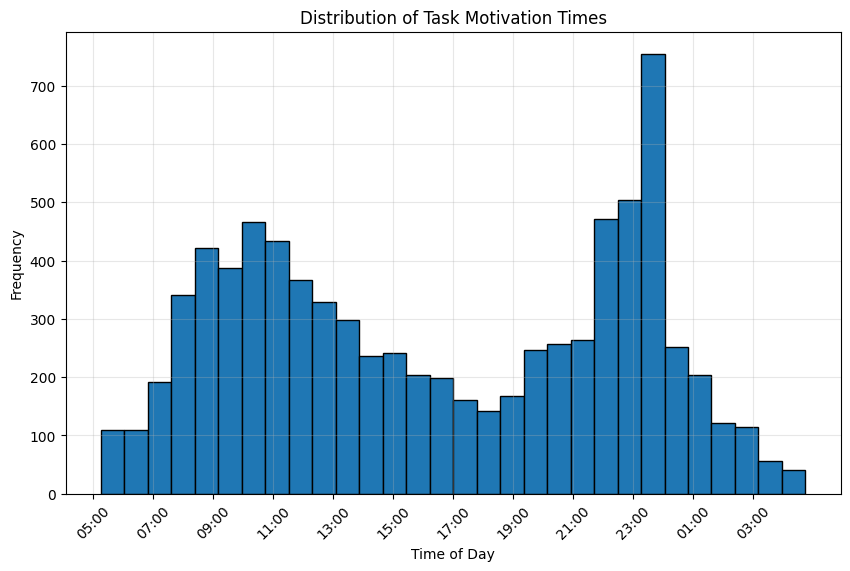

In [152]:
# Plot histogram of time subjects start tasks
# Convert minutes after 5am to actual times for x-axis labels
plt.figure(figsize=(10, 6))
plt.hist(df_daily.task_motivation_min_after_5am, bins=30, edgecolor='black')
plt.title('Distribution of Task Motivation Times')
plt.xlabel('Time of Day')
plt.ylabel('Frequency')

# Get current axis
ax = plt.gca()

# Set x-ticks every 2 hours (120 minutes)
xticks = np.arange(0, 24*60, 120)
ax.set_xticks(xticks)

# Convert minutes after 5am to time strings
def mins_to_time(mins):
    hours = ((mins // 60) + 5) % 24  # Add 5 hours and wrap around 24
    return f'{int(hours):02d}:00'

ax.set_xticklabels([mins_to_time(x) for x in xticks], rotation=45)
plt.grid(True, alpha=0.3)

In [153]:
# Rename task_nback_mode to task_nback_choseHard
df_daily = df_daily.rename(columns={'task_nback_mode': 'task_nback_choseHard'})

# Rename css to task_css
df_daily = df_daily.rename(columns={'css': 'task_css'})

# Map 'hard' to 1 and 'easy' to 0
df_daily['task_nback_choseHard'] = df_daily['task_nback_choseHard'].map({'hard': 1, 'easy': 0})

In [154]:
# Convert task_hanoi_solved from boolean to numeric (1/0), preserving NaN values
df_daily['task_hanoi_solved'] = df_daily['task_hanoi_solved'].map({True: 1, False: 0})

In [155]:
# Get list of numeric columns
numeric_cols = df_daily.select_dtypes(include=['int64', 'float64']).columns

# Add back PID column
cols_to_keep = list(numeric_cols) + ['PID']

# Drop duplicates to get unique columns
cols_to_keep = list(dict.fromkeys(cols_to_keep))

# Keep only specified columns
df_daily = df_daily[cols_to_keep]

In [156]:
# Add drift data

# rename subj to PID
drift = drift.rename(columns={'subj': 'PID', 'allCogDTNormDDM2': 'task_drift_DDM'})
drift = drift[['PID', 'day', 'task_drift_DDM']]

df_daily = pd.merge(df_daily, drift, on=['PID', 'day'], how='left')

### Clean Passive Data

**Sensor drop out issue**

Given that we had a drop out in sensor collection data around day 60 for many subjects in cohort 2, due to an unfortunate platform update, we don't want to treat zeros that start at this point as valid values, but rather remove them.

In [157]:
def remove_trailing_zeros(df):
    """
    Remove trailing zeros (convert to NaN) if there are 4 or more consecutive trailing zeros
    for each variable for each PID.
    """
    df_clean = df.copy()
    
    # Get all columns except PID and day
    value_columns = [col for col in df.columns if col not in ['PID', 'day']]
    
    # Process each subject
    for pid in df['PID'].unique():
        subject_data = df_clean[df_clean['PID'] == pid].copy()
        subject_data = subject_data.sort_values('day').reset_index(drop=True)
        
        # Process each variable
        for col in value_columns:
            values = subject_data[col].values
            
            # Skip if all values are missing
            if pd.isna(values).all():
                continue
            
            # Find the last non-missing index
            non_missing_mask = ~pd.isna(values)
            if not non_missing_mask.any():
                continue
                
            last_non_missing_idx = np.where(non_missing_mask)[0][-1]
            
            # Check if the last non-missing value is 0
            if values[last_non_missing_idx] == 0:
                # Count consecutive zeros going backwards from the end
                consecutive_zeros = 0
                
                # Start from the last non-missing index and go backwards
                for i in range(last_non_missing_idx, -1, -1):
                    if pd.isna(values[i]):
                        break
                    elif values[i] == 0:
                        consecutive_zeros += 1
                    else:
                        break
                
                # If 4 or more consecutive trailing zeros, replace with NaN
                if consecutive_zeros >= 4:
                    start_idx = last_non_missing_idx - consecutive_zeros + 1
                    end_idx = last_non_missing_idx + 1
                    
                    # Get the actual indices in the original dataframe
                    subject_indices = subject_data.index[start_idx:end_idx]
                    original_indices = df_clean[df_clean['PID'] == pid].sort_values('day').index[start_idx:end_idx]
                    
                    # Replace with NaN in the original dataframe
                    df_clean.loc[original_indices, col] = np.nan
                    
                    print(f"PID {pid}, {col}: Replaced {consecutive_zeros} trailing zeros with NaN (days {subject_data.loc[start_idx:end_idx-1, 'day'].min()}-{subject_data.loc[end_idx-1, 'day']})")
    
    return df_clean

# Apply the function to clean trailing zeros
print("Cleaning trailing zeros...")
df_daily_clean = remove_trailing_zeros(df_daily)

# Show summary of changes
print(f"\nSummary:")
print(f"Original dataframe shape: {df_daily.shape}")
print(f"Cleaned dataframe shape: {df_daily_clean.shape}")

# Count how many values were changed to NaN
value_columns = [col for col in df_daily.columns if col not in ['PID', 'day']]
total_changes = 0

for col in value_columns:
    original_non_nan = (~pd.isna(df_daily[col])).sum()
    cleaned_non_nan = (~pd.isna(df_daily_clean[col])).sum()
    changes = original_non_nan - cleaned_non_nan
    total_changes += changes
    
    if changes > 0:
        print(f"{col}: {changes} values converted to NaN")

print(f"\nTotal values converted to NaN: {total_changes}")

# Update df_daily to use the cleaned version
df_daily = df_daily_clean.copy()

Cleaning trailing zeros...
PID 0151d9f1-1644-4437-805e-02f5e244a690, sr_DAILY_past24_drinks: Replaced 20 trailing zeros with NaN (days 65-84)
PID 0151d9f1-1644-4437-805e-02f5e244a690, sr_DAILY_past24_leisureNonSoloPhysical: Replaced 18 trailing zeros with NaN (days 67-84)
PID 0151d9f1-1644-4437-805e-02f5e244a690, sr_DAILY_past24_leisureSoloMental: Replaced 20 trailing zeros with NaN (days 65-84)
PID 0151d9f1-1644-4437-805e-02f5e244a690, sr_DAILY_past24_leisureSoloPhysical: Replaced 20 trailing zeros with NaN (days 65-84)
PID 0151d9f1-1644-4437-805e-02f5e244a690, sr_DAILY_past24_nonoccupation: Replaced 12 trailing zeros with NaN (days 73-84)
PID 0151d9f1-1644-4437-805e-02f5e244a690, sr_DAILY_past24_gapCause_external: Replaced 13 trailing zeros with NaN (days 72-84)
PID 0151d9f1-1644-4437-805e-02f5e244a690, task_gng_incorrectGo: Replaced 15 trailing zeros with NaN (days 70-84)
PID 0151d9f1-1644-4437-805e-02f5e244a690, task_psat_flag_sub100RT_n: Replaced 84 trailing zeros with NaN (days 1

Create column that controls for the amount of typing when providing sentiment analysis values

In [158]:
# Get all device sentiment combined columns
sentiment_cols = [col for col in df_daily.columns if 'device_sentiment_combined' in col]

# Create ratio columns by dividing by typing duration
for col in sentiment_cols:
    new_col_name = col + '_ratio'
    df_daily[new_col_name] = df_daily[col] / df_daily['passive_sk_keyboard_total_typing_duration']

print(f"Created {len(sentiment_cols)} ratio columns:")
for col in sentiment_cols:
    print(f"  {col} -> {col}_ratio")

Created 10 ratio columns:
  passive_sk_device_sentiment_combined_absolutist -> passive_sk_device_sentiment_combined_absolutist_ratio
  passive_sk_device_sentiment_combined_anger -> passive_sk_device_sentiment_combined_anger_ratio
  passive_sk_device_sentiment_combined_anxiety -> passive_sk_device_sentiment_combined_anxiety_ratio
  passive_sk_device_sentiment_combined_confused -> passive_sk_device_sentiment_combined_confused_ratio
  passive_sk_device_sentiment_combined_death -> passive_sk_device_sentiment_combined_death_ratio
  passive_sk_device_sentiment_combined_down -> passive_sk_device_sentiment_combined_down_ratio
  passive_sk_device_sentiment_combined_health -> passive_sk_device_sentiment_combined_health_ratio
  passive_sk_device_sentiment_combined_lowEnergy -> passive_sk_device_sentiment_combined_lowEnergy_ratio
  passive_sk_device_sentiment_combined_positive -> passive_sk_device_sentiment_combined_positive_ratio
  passive_sk_device_sentiment_combined_sad -> passive_sk_device_sen

### Add Targets

Based on `Gap_Weighting.ipynb`, using the MLM model with correlation of .484 with `sr_affect_net_avg`

| measure                  | weights   |
|--------------------------|----------:|
| values_adherence         | 0.530248  |
| overall_goal_completion  | 0.249118  |
| goal1_completion         | 0.146432  |
| goal2_completion         | 0.074202  |

In [159]:
# Flip goal accomplishment to be report gap
df_daily['values_gap'] = 100 - df_daily['sr_DAILY_past24_values']
df_daily['goal1_gap'] = 100 - df_daily['sr_DAILY_goal1_report']
df_daily['goal2_gap'] = 100 - df_daily['sr_DAILY_goal2_report']

In [160]:
# Create weighted well-being gap target
def calculate_wbw_gap(row):
    # Define features and their weights
    feature_weights = {
        'values_gap': 0.530248,
        'sr_DAILY_past24_gap': 0.249118, 
        'goal1_gap': 0.146432,
        'goal2_gap': 0.074202
    }
    
    # Get available features (not NaN)
    available_features = {k:v for k,v in feature_weights.items() 
                        if not pd.isna(row[k])}
    
    # If no features available, return NaN
    if len(available_features) == 0:
        return np.nan
        
    # Renormalize weights of available features
    weight_sum = sum(available_features.values())
    normalized_weights = {k:v/weight_sum for k,v in available_features.items()}
    
    # Calculate weighted sum
    weighted_sum = sum(row[k] * v for k,v in normalized_weights.items())
    
    return weighted_sum

# Apply calculation to create new feature
df_daily['target_wbw_gap'] = df_daily.apply(calculate_wbw_gap, axis=1)

#### Mean of Three Gaps

Unweighted

In [161]:
# Calculate target
df_daily['target_gap3_mean'] = df_daily[['goal1_gap', 'goal2_gap', 'sr_DAILY_past24_gap']].mean(axis=1)

#### Affect Target (pm)
Net affect (i.e. average of positive - average of neative)

In [162]:
# Calculate target
df_daily['target_net_affect_avg'] = (
    df_daily[[col for col in df_daily.columns 
                    if col.startswith('affect_pos') and not col.endswith('_am')]].mean(axis=1) -
    df_daily[[col for col in df_daily.columns 
                    if col.startswith('affect_neg') and not col.endswith('_am')]].mean(axis=1)
)

### Take Means

In [163]:
# Drop day_of_week column
df_daily = df_daily.drop('day_of_week', axis=1)

In [164]:
# Handle outliers using IQR method before calculating means
# Get numeric columns only (excluding 'PID')
numeric_cols = df_daily.select_dtypes(include=['number']).columns.tolist()
if 'PID' in numeric_cols:
    numeric_cols.remove('PID')

# Apply outlier capping to each numeric column
for col in numeric_cols:
    # Calculate Q1, Q3, and IQR
    Q1 = df_daily[col].quantile(0.25)
    Q3 = df_daily[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define upper and lower bounds
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # Cap outliers
    df_daily[col] = df_daily[col].clip(lower=lower_bound, upper=upper_bound)

In [165]:
# Prepend 'daily_' to all column names except PID
rename_dict = {col: f'daily_{col}' for col in df_daily.columns if col != 'PID'}
df_daily = df_daily.rename(columns=rename_dict)

In [166]:
# Calculate average of month1 and month2 for goal1 where both values exist
mask = df_daily['daily_sr_DAILY_goal1_interaction_month1'].notna() & df_daily['daily_sr_DAILY_goal1_interaction_month2'].notna()
df_daily.loc[mask, 'daily_sr_DAILY_goal1_interaction_month'] = (
    df_daily.loc[mask, 'daily_sr_DAILY_goal1_interaction_month1'] + 
    df_daily.loc[mask, 'daily_sr_DAILY_goal1_interaction_month2']
) / 2

# Calculate average of week1 and week2 for goal1 where both values exist
mask = df_daily['daily_sr_DAILY_goal1_interaction_week1'].notna() & df_daily['daily_sr_DAILY_goal1_interaction_week2'].notna()
df_daily.loc[mask, 'daily_sr_DAILY_goal1_interaction_week'] = (
    df_daily.loc[mask, 'daily_sr_DAILY_goal1_interaction_week1'] + 
    df_daily.loc[mask, 'daily_sr_DAILY_goal1_interaction_week2']
) / 2

# Calculate average of month1 and month2 for goal2 where both values exist
mask = df_daily['daily_sr_DAILY_goal2_interaction_month1'].notna() & df_daily['daily_sr_DAILY_goal2_interaction_month2'].notna()
df_daily.loc[mask, 'daily_sr_DAILY_goal2_interaction_month'] = (
    df_daily.loc[mask, 'daily_sr_DAILY_goal2_interaction_month1'] + 
    df_daily.loc[mask, 'daily_sr_DAILY_goal2_interaction_month2']
) / 2

# Calculate average of week1 and week2 for goal2 where both values exist
mask = df_daily['daily_sr_DAILY_goal2_interaction_week1'].notna() & df_daily['daily_sr_DAILY_goal2_interaction_week2'].notna()
df_daily.loc[mask, 'daily_sr_DAILY_goal2_interaction_week'] = (
    df_daily.loc[mask, 'daily_sr_DAILY_goal2_interaction_week1'] + 
    df_daily.loc[mask, 'daily_sr_DAILY_goal2_interaction_week2']
) / 2

In [167]:
# Combine weekly goal interactions for goal1 and goal2
mask = df_daily['daily_sr_DAILY_goal1_interaction_week'].notna() & df_daily['daily_sr_DAILY_goal2_interaction_week'].notna()
df_daily.loc[mask, 'daily_sr_daily_weekly_goal_interaction'] = (
    df_daily.loc[mask, 'daily_sr_DAILY_goal1_interaction_week'] + 
    df_daily.loc[mask, 'daily_sr_DAILY_goal2_interaction_week']
) / 2

# Combine monthly goal interactions for goal1 and goal2
mask = df_daily['daily_sr_DAILY_goal1_interaction_month'].notna() & df_daily['daily_sr_DAILY_goal2_interaction_month'].notna()
df_daily.loc[mask, 'daily_sr_daily_monthly_goal_interaction'] = (
    df_daily.loc[mask, 'daily_sr_DAILY_goal1_interaction_month'] + 
    df_daily.loc[mask, 'daily_sr_DAILY_goal2_interaction_month']
) / 2

In [168]:
# Combine goal1 and goal2 measures into single measures
goal_measures = [
    'confidence',
    'consequences',
    'effort',
    'importance',
    'motivationExternal',
    'motivationInternal'
]

# Process each measure type
for measure in goal_measures:
    # Create column names for goal1 and goal2
    goal1_col = f'daily_sr_DAILY_goal1_{measure}'
    goal2_col = f'daily_sr_DAILY_goal2_{measure}'
    combined_col = f'daily_sr_daily_goals_{measure}'
    
    # Find rows where both goal1 and goal2 measures exist
    mask = df_daily[goal1_col].notna() & df_daily[goal2_col].notna()
    
    # Calculate the average of goal1 and goal2 measures
    df_daily.loc[mask, combined_col] = (
        df_daily.loc[mask, goal1_col] + 
        df_daily.loc[mask, goal2_col]
    ) / 2

# Handle the special case for interaction_eachOther which only exists for goal2
# We'll just copy it to a new column with a more consistent naming pattern
if 'daily_sr_DAILY_goal2_interaction_eachOther' in df_daily.columns:
    df_daily['daily_sr_daily_goals_interaction_eachOther'] = df_daily['daily_sr_DAILY_goal2_interaction_eachOther']


In [169]:
# create columns that don't exist yet
df_daily['daily_task_stroop_interference'] = df_daily['daily_task_stroop_incongruentAvgRT'] - df_daily['daily_task_stroop_congruentAvgRT']
df_daily['daily_task_emoStroop_totalCorrectProp'] = (df_daily['daily_task_emoStroop_accuracy_incongruent'] + df_daily['daily_task_emoStroop_accuracy_congruent']) / 2

In [170]:
# move the individual goal variables to be associated with the day they were attempted
# i.e. subjects report on their goals for the next day, so we want their goal completion to be 
# related to the goal properties for THAT DAY, which they report the day BEFORE

# List of columns to shift
cols_to_shift = [
    'daily_sr_daily_goals_confidence',
    'daily_sr_daily_goals_consequences',
    'daily_sr_daily_goals_effort',
    'daily_sr_daily_goals_importance',
    'daily_sr_daily_goals_motivationExternal',
    'daily_sr_daily_goals_motivationInternal',
    'daily_sr_daily_weekly_goal_interaction',
    'daily_sr_daily_monthly_goal_interaction',
    'daily_sr_daily_goals_interaction_eachOther'
]

# Apply the shift operation within each PID group
df_daily[cols_to_shift] = df_daily.groupby('PID')[cols_to_shift].shift(1)

In [171]:
# Group by PID and calculate mean for all numeric columns
df_daily_means = df_daily.groupby('PID').mean().reset_index()

### Data Categories

#### Passive

In [172]:
daily_passive_selected_dvs = [col for col in df_daily if 'daily_passive' in col.lower()]

# Remove redundant sentiment variables
daily_passive_selected_dvs = [col for col in daily_passive_selected_dvs if 'sentiment_word' not in col.lower() and 'sentiment_emoji' not in col.lower() and 'keyboard_sentiment_combined' not in col.lower()]

# Remove cycling as basically empty - using list filtering instead of .drop()
daily_passive_selected_dvs = [col for col in daily_passive_selected_dvs if col != 'daily_passive_hk_activity_distanceCycling']

# Remove all variables with sleep other than sr_DAILY_currentDay_sleep and passive_hk_sleep_inBed
daily_passive_selected_dvs = [col for col in daily_passive_selected_dvs if 'sleep' not in col.lower() or 'sr_DAILY_currentDay_sleep' in col or 'passive_hk_sleep_inBed' in col]

# Remove variables with string _app_usage or _web_usage as we have combined values for these
daily_passive_selected_dvs = [col for col in daily_passive_selected_dvs if 'app_usage' not in col.lower() and 'web_usage' not in col.lower()]

# Remove variables with string _gym_ and _school_ as these are mostly empty
daily_passive_selected_dvs = [col for col in daily_passive_selected_dvs if 'gym' not in col.lower() and 'school' not in col.lower()]

# Print the length of the list to see how many variables we have
print(f"Number of selected daily passive variables: {len(daily_passive_selected_dvs)}")

Number of selected daily passive variables: 91


#### Self Report

In [173]:
daily_self_report_selected_dvs = [col for col in df_daily_means.columns if '_sr_' in col.lower()]

# Remove any variables that contain string gap_heuristic
daily_self_report_selected_dvs = [col for col in daily_self_report_selected_dvs if 'gap_heuristic' not in col.lower()]

# Remove daily_sr_DAILY_past24_gap, daily_sr_gap_simple, daily_sr_DAILY_past24_values and daily_sr_dailySR_zeroVar_cols
daily_self_report_selected_dvs = [col for col in daily_self_report_selected_dvs if 'daily_sr_DAILY_past24_gap' not in col and 'daily_sr_gap_simple' not in col and 'daily_sr_DAILY_past24_values' not in col and 'daily_sr_dailySR_zeroVar_cols' not in col]
# Remove components of the gap outcome measure
daily_self_report_selected_dvs = [col for col in daily_self_report_selected_dvs if '_report' not in col]
# Remove other closely related variables to the gap outcome measure
daily_self_report_selected_dvs = [col for col in daily_self_report_selected_dvs if 'productivity' not in col]

# Remove elements with string past48to24
daily_self_report_selected_dvs = [col for col in daily_self_report_selected_dvs if 'past48to24' not in col]

# Remove outcome variables
daily_self_report_selected_dvs = [col for col in daily_self_report_selected_dvs if 'daily_sr_affect_net_avg' not in col and 'daily_sr_DAILY_past24_ideal' not in col and 'daily_sr_DAILY_past24_change' not in col and 'daily_sr_DAILY_past24_satisfaction' not in col]

# daily_sr_DAILY_past24_diet as it is just the inverse of daily_sr_DAILY_gap_diet
daily_self_report_selected_dvs = [col for col in daily_self_report_selected_dvs if 'daily_sr_DAILY_past24_diet' not in col]

# Remove the individual components from daily_self_report_selected_dvs
columns_to_remove = [
    'daily_sr_DAILY_goal1_interaction_month1',
    'daily_sr_DAILY_goal1_interaction_month2',
    'daily_sr_DAILY_goal1_interaction_week1',
    'daily_sr_DAILY_goal1_interaction_week2',
    'daily_sr_DAILY_goal2_interaction_month1',
    'daily_sr_DAILY_goal2_interaction_month2',
    'daily_sr_DAILY_goal2_interaction_week1',
    'daily_sr_DAILY_goal2_interaction_week2',
    # Original goal measures that were combined
    'daily_sr_DAILY_goal1_confidence',
    'daily_sr_DAILY_goal2_confidence',
    'daily_sr_DAILY_goal1_consequences',
    'daily_sr_DAILY_goal2_consequences',
    'daily_sr_DAILY_goal1_effort',
    'daily_sr_DAILY_goal2_effort',
    'daily_sr_DAILY_goal1_importance',
    'daily_sr_DAILY_goal2_importance',
    'daily_sr_DAILY_goal1_motivationExternal',
    'daily_sr_DAILY_goal2_motivationExternal',
    'daily_sr_DAILY_goal1_motivationInternal',
    'daily_sr_DAILY_goal2_motivationInternal',
    
    # Original variable that was renamed
    'daily_sr_DAILY_goal2_interaction_eachOther'
]

daily_self_report_selected_dvs = [col for col in daily_self_report_selected_dvs if col not in columns_to_remove]


# Remove individual goal interaction components from daily_self_report_selected_dvs
additional_columns_to_remove = [
    'daily_sr_DAILY_goal1_interaction_week',
    'daily_sr_DAILY_goal2_interaction_week',
    'daily_sr_DAILY_goal1_interaction_month',
    'daily_sr_DAILY_goal2_interaction_month'
]

daily_self_report_selected_dvs = [col for col in daily_self_report_selected_dvs if col not in additional_columns_to_remove]

# Print the length of the list to see how many variables we have
print(f"Number of selected daily passive variables: {len(daily_self_report_selected_dvs)}")

Number of selected daily passive variables: 45


#### Task

In [174]:
# Create a list of selected daily task dependent variables
daily_task_selected_dvs = [
    'daily_task_css',
    'daily_task_drift_DDM',
    'daily_task_spatialSpan_score',
    'daily_task_psat_efficiency',
    'daily_task_psat_accuracy',
    'daily_task_rt_avgRT',
    'daily_task_trailmaking_efficiency',
    'daily_task_hanoi_solved',
    'daily_task_hanoi_extraMoves',
    'daily_task_hanoi_movesTime',
    'daily_task_stroop_totalCorrectProp',
    'daily_task_stroop_efficiency',
    'daily_task_stroop_interference',
    'daily_task_bart_score',
    'daily_task_bart_avg_rt',
    'daily_task_nback_F1',
    #'daily_task_nback_accuracy',
    'daily_task_nback_matched',
    'daily_task_nback_choseHard',
    'daily_task_gng_avgRt',
    'daily_task_gng_d_prime',
    'daily_task_emoStroop_totalCorrectProp',
    'daily_task_emoStroop_efficiency',
    'daily_task_emoStroop_interference',
    'daily_task_motivation_level',
    'daily_task_motivation_min_after_5am',
    'daily_task_nasa_distraction',
    'daily_task_nasa_effort',
    'daily_task_nasa_frustration',
    'daily_task_nasa_luck',
    'daily_task_nasa_mental_demand',
    'daily_task_nasa_performance',
    'daily_task_nasa_temporal_demand'
]

# Verify the number of variables in the list
print(f"Number of selected daily task variables: {len(daily_task_selected_dvs)}")

Number of selected daily task variables: 32


#### Outcome

In [175]:
daily_outcomes_selected_dvs = [col for col in df_daily_means.columns if 'affect' in col]

# remove  'daily_affect_zeroVar_cols' and 'daily_affect_pct_zeroVarRows'
daily_outcomes_selected_dvs = [col for col in daily_outcomes_selected_dvs if 'daily_affect_zeroVar_cols' not in col and 'daily_affect_pct_zeroVarRows' not in col]

# remove daily_target_net_affect_avg
daily_outcomes_selected_dvs = [col for col in daily_outcomes_selected_dvs if 'daily_target_net_affect_avg' not in col]

# add daily_sr_DAILY_past24_ideal and daily_sr_DAILY_past24_change and daily_sr_DAILY_past24_satisfaction
daily_outcomes_selected_dvs.append('daily_sr_DAILY_past24_ideal')
daily_outcomes_selected_dvs.append('daily_sr_DAILY_past24_change')
daily_outcomes_selected_dvs.append('daily_sr_DAILY_past24_satisfaction')

# Verify the number of variables in the list
print(f"Number of selected daily outcome variables: {len(daily_outcomes_selected_dvs)}")

Number of selected daily outcome variables: 44


#### Clean things up

In [176]:
# Rename day column
df_daily = df_daily.rename(columns={'daily_day': 'day'})

# Get target columns
target_cols = [col for col in df_daily.columns if 'target' in col]

# Filter for selected columns
df_daily_selected = df_daily[['PID', 'day'] + daily_self_report_selected_dvs + daily_task_selected_dvs + daily_passive_selected_dvs + daily_outcomes_selected_dvs + target_cols]

# Rename columns in df_daily that are in daily_outcomes_selected_dvs
# Add 'outcome_' after 'daily_' in column names
for col in df_daily_selected.columns:
    if col in daily_outcomes_selected_dvs and col.startswith('daily_'):
        new_col_name = col.replace('daily_', 'daily_outcome_', 1)
        df_daily_selected = df_daily_selected.rename(columns={col: new_col_name})

## Process battery data

In [100]:
# Process r1_battery
onb_cols_r1 = [col for col in r1_battery.columns if col.startswith('onB_')]
offb_cols_r1 = [col for col in r1_battery.columns if col.startswith('offB_')]

onb_stripped_r1 = [col.replace('onB_', '') for col in onb_cols_r1]
offb_stripped_r1 = [col.replace('offB_', '') for col in offb_cols_r1]

common_cols_r1 = set(onb_stripped_r1).intersection(set(offb_stripped_r1))

avg_df_r1 = pd.DataFrame()
id_cols = ['ParticipantIdentifier']
avg_df_r1[id_cols] = r1_battery[id_cols]

for col in common_cols_r1:
    onb_col = 'onB_' + col
    offb_col = 'offB_' + col
    
    onb_vals = r1_battery[onb_col]
    offb_vals = r1_battery[offb_col]
    
    avg_df_r1[col + '_avg'] = pd.DataFrame({
        'onb': onb_vals,
        'offb': offb_vals
    }).mean(axis=1, skipna=True)

# Add cohort column
avg_df_r1['cohort'] = 1

# Process r2_battery
onb_cols_r2 = [col for col in r2_battery.columns if col.startswith('onB_')]
offb_cols_r2 = [col for col in r2_battery.columns if col.startswith('offB_')]

onb_stripped_r2 = [col.replace('onB_', '') for col in onb_cols_r2]
offb_stripped_r2 = [col.replace('offB_', '') for col in offb_cols_r2]

common_cols_r2 = set(onb_stripped_r2).intersection(set(offb_stripped_r2))

avg_df_r2 = pd.DataFrame()
avg_df_r2[id_cols] = r2_battery[id_cols]

for col in common_cols_r2:
    onb_col = 'onB_' + col
    offb_col = 'offB_' + col
    
    onb_vals = r2_battery[onb_col]
    offb_vals = r2_battery[offb_col]
    
    avg_df_r2[col + '_avg'] = pd.DataFrame({
        'onb': onb_vals,
        'offb': offb_vals
    }).mean(axis=1, skipna=True)

# Add cohort column
avg_df_r2['cohort'] = 2

# Combine both dataframes
df_battery = pd.concat([avg_df_r1, avg_df_r2], ignore_index=True)

In [101]:
# Remove effort avoidance task score column
df_battery = df_battery.drop('effort_avoidance_task_score_avg', axis=1)

# remove perfectly correlated columns
df_battery = df_battery.drop('probabilistic_selc_task_positive_learning_bias_avg', axis=1)
df_battery = df_battery.drop('cognitive_ref_task_intuitive_prop_avg', axis=1)
df_battery = df_battery.drop('shift_task_num_trials_avg', axis=1)

In [102]:
# Remove 'trait_' prefix from column names
df_battery = df_battery.rename(columns={
    'trait_hedonic_capacity_score_avg': 'hedonic_capacity_score_avg',
    'trait_robustness_of_self_confidence_score_avg': 'robustness_of_self_confidence_score_avg', 
    'trait_emotional_intelligence_score_avg': 'emotional_intelligence_score_avg'
})

In [103]:
# change name of life_orientation_test_score_avg to optimism_score_avg
df_battery = df_battery.rename(columns={'life_orientation_test_score_avg': 'optimism_score_avg'})
# scale is reversed, so need to flip it (1 = I agree a lot, 5 = I disagree a lot)
df_battery['optimism_score_avg'] = 6 - df_battery['optimism_score_avg']

# change name of leisure_time_activity_score_avg to physical_activity_score_avg
df_battery = df_battery.rename(columns={'leisure_time_activity_score_avg': 'physical_activity_score_avg'})

# change name of grades_avg_avg to rw_grades_avg
df_battery = df_battery.rename(columns={'grades_avg_avg': 'rw_grades_avg'})

# change name of bmi_avg to rw_bmi_avg
df_battery = df_battery.rename(columns={'bmi_avg': 'rw_bmi_avg'})

# change name of domain_gap_avg to rw_intention_behavior_gap_avg
df_battery = df_battery.rename(columns={'domain_gap_avg': 'rw_intention_behavior_gap_avg'})

# change name of maximizing_scale_MTS_avg to maximizing_tendency_scale_avg
df_battery = df_battery.rename(columns={'maximizing_scale_MTS_avg': 'maximizing_tendency_scale_avg'})


In [104]:
# Combine competetiveness_index_contentiousness_avg and competetiveness_index_enjoyment_avg
# to create competitiveness_overall_avg

df_battery['competitiveness_overall_avg'] = (df_battery['competetiveness_index_contentiousness_avg'] +
                                             df_battery['competetiveness_index_enjoyment_avg']) / 2

In [105]:
# Reverse K6 survey score by subtracting from 36 (max possible score)
df_battery['k6_survey_score_avg'] = 36 - df_battery['k6_survey_score_avg']

In [106]:
# Reverse propensity to plan (originally 1 = almost always, 6 = almost never)
df_battery['propensity_to_plan_mlr_avg'] = 7 - df_battery['propensity_to_plan_mlr_avg']
df_battery['propensity_to_plan_msr_avg'] = 7 - df_battery['propensity_to_plan_msr_avg']
df_battery['propensity_to_plan_tlr_avg'] = 7 - df_battery['propensity_to_plan_tlr_avg']
df_battery['propensity_to_plan_tsr_avg'] = 7 - df_battery['propensity_to_plan_tsr_avg']

# Create single variable for long-run and short-run propensity to plan as they are highly correlated
df_battery['propensity_to_plan_avg'] = (df_battery['propensity_to_plan_mlr_avg'] + 
                                        df_battery['propensity_to_plan_tlr_avg'] + 
                                        df_battery['propensity_to_plan_msr_avg'] +
                                        df_battery['propensity_to_plan_tsr_avg']
                                        ) / 4

# Save df
df_battery.to_csv('../../../3_3_2_processed_data/battery_data.csv', index=False)

In [107]:
task_cols = [
    'attention_network_task_acc_avg', # overall accuracy
    # 'attention_network_task_alerting_acc_avg',
    'attention_network_task_alerting_rt_avg', # executive control
    # 'attention_network_task_conflict_acc_avg',
    # 'attention_network_task_conflict_rt_avg',
    # 'attention_network_task_congruent_rt_avg',
    # 'attention_network_task_incongruent_rt_avg',
    # 'attention_network_task_missed_percent_avg',
    # 'attention_network_task_neutral_rt_avg',
    # 'attention_network_task_orienting_acc_avg',
    # 'attention_network_task_orienting_rt_avg',
    # 'attention_network_task_post_error_slowing_avg',
    'berlin_numeracy_task_score_avg',
    'cognitive_estimation_task_score_avg',
    'cognitive_ref_task_correct_prop_avg',
    #'cognitive_ref_task_intuitive_prop_avg',
    #'effort_avoidance_task_score_avg', # data seems to be either 200 or nan
    'go_nogo_task_bias_avg', # response bias
    'go_nogo_task_dprime_avg', # sensitivity/discrimination
    'holt_laury_task_score_avg',
    # 'information_sampling_task_decreasing_win_acc_avg',
    'information_sampling_task_decreasing_win_total_points_avg',
    # 'information_sampling_task_fixed_win_acc_avg',
    'information_sampling_task_fixed_win_total_points_avg',
    'jdm_classics_task_score_avg',
    'keep_track_task_score_avg',
    'plus_minus_task_score_avg',
    #'probabilistic_selc_task_log_ll_avg',
    #'probabilistic_selc_task_missed_percent_avg',
    #'probabilistic_selc_task_num_trials_avg',
    'probabilistic_selc_task_overall_test_acc_avg', # overall learning
    #'probabilistic_selc_task_positive_learning_bias_avg',
    'probabilistic_selc_task_value_sensitivity_avg',
    'psychomotor_vigilance_score_avg',
    'ravens_task_score_avg',
    # 'semantic_verbal_fluency_task_animals_words_num_avg',
    # 'semantic_verbal_fluency_task_f_words_num_avg',
    # 'semantic_verbal_fluency_task_jobs_words_num_avg',
    # 'semantic_verbal_fluency_task_s_words_num_avg',
    'semantic_verbal_fluency_task_total_avg',
    'shift_task_acc_avg', # overall accuracy
    #'shift_task_avg_rt_avg',
    #'shift_task_conceptual_responses_avg', # conceptual understanding
    #'shift_task_fail_to_maintain_set_avg',
    #'shift_task_missed_percent_avg',
    #'shift_task_num_trials_avg',
    'shift_task_std_rt_avg',
    'simon_task_acc_avg', # overall accuracy
    #'simon_task_congruent_acc_avg',
    #'simon_task_congruent_avg_rt_avg',
    #'simon_task_congruent_seq_rt_avg',
    #'simon_task_incongruent_acc_avg',
    'simon_task_incongruent_avg_rt_avg', # interference effect
    #'simon_task_incongruent_seq_acc_avg',
    #'simon_task_missed_percent_avg',
    #'simon_task_post_error_slowing_avg',
    #'simon_task_rt_avg',
    'simple_reaction_time_task_avg_rt_avg',
    'simple_reaction_time_task_missed_percent_avg',
    'stroop_task_accuracy_avg', # overall accuracy
    #'stroop_task_con_avg_avg',
    #'stroop_task_con_sd_avg',
    'stroop_task_effect_avg', # interference effect
    #'stroop_task_incon_avg_avg',
    #'stroop_task_incon_sd_avg',
    #'TOL_task_avg_move_time_avg',
    #'TOL_task_num_correct_avg', # planning abilitiy
    #'TOL_task_num_extra_moves_avg',
    #'TOL_task_num_optimal_solutions_avg',
    'TOL_task_planning_time_avg', # efficiency
    'TOL_task_weighted_performance_score_avg',
    #'two_stage_task_avg_rt_avg',
    #'two_stage_task_missed_percent_avg'
]

# Rename trait columns 
survey_cols = [
    'ambition_score_avg',
    'boredom_proneness_score_avg',
    'brief_self_control_score_avg',
    #'bsss_boredom_sus_avg',
    #'bsss_disinhibition_avg',
    #'bsss_exp_seek_avg',
    'bsss_overall_avg',
    #'bsss_thrill_avg',
    #'competetiveness_index_contentiousness_avg',
    #'competetiveness_index_enjoyment_avg',
    'competitiveness_overall_avg',
    #'competetiveness_index_enjoyment_overall_avg',
    'con_hex_score_avg',
    'food_fat_score_avg',
    'food_fruitveg_score_avg',
    'future_time_perspective_score_avg',
    'general_self_efficacy_score_avg',
    #'grit_scale_CI_avg',
    #'grit_scale_PE_avg',
    'grit_scale_score_avg', 
    #'maximizing_scale_alt_search_avg',
    #'maximizing_scale_dec_difficulty_avg',
    #'maximizing_scale_high_standards_avg',
    'maximizing_tendency_scale_avg',
    #'maximizing_scale_overall_avg',
    #'maximizing_scale_SMTS_avg',
    'mindful_attention_avg',
    'need_for_cognition_score_avg',
    'optimism_score_avg',
    # 'PANAS_positive_affect_avg',
    # 'PANAS_negative_affect_avg',
    'physical_activity_score_avg',
    #'propensity_to_plan_mlr_avg',
    #'propensity_to_plan_msr_avg',
    #'propensity_to_plan_tlr_avg',
    #'propensity_to_plan_tsr_avg',
    'propensity_to_plan_avg',
    #'secular_measure_work_ethic_cli_avg',
    #'secular_measure_work_ethic_iwm_avg',
    #'secular_measure_work_ethic_moral_avg',
    'secular_measure_work_ethic_score_avg',
    'social_des_score_avg',
    'emotional_intelligence_score_avg',
    'hedonic_capacity_score_avg',
    'robustness_of_self_confidence_score_avg'
]

# Rename outcome columns
outcome_cols_all = [
    #'DASS_anxiety_avg',
    #'DASS_depression_avg',
    'DASS_overall_avg',
    #'DASS_stress_avg',
    'flourishing_score_avg',
    'harmony_score_avg',
    'k6_survey_score_avg',
    'PANAS_positive_affect_avg',
    'PANAS_negative_affect_avg',
    'perceived_stress_score_avg',
    'qol_score_avg',
    'rosenberg_SES_score_avg',
    'sat_life_score_avg',
    'sub_happy_score_avg',
    'well_being_avg',
    # real world outcomes
    'rw_bmi_avg',
    'rw_grades_avg',
    'rw_intention_behavior_gap_avg',
]

# Add prefixes
df_battery = df_battery.rename(columns={col: f'battery_task_{col}' for col in task_cols})
df_battery = df_battery.rename(columns={col: f'battery_trait_{col}' for col in survey_cols})
df_battery = df_battery.rename(columns={col: f'battery_outcome_{col}' for col in outcome_cols_all})

# Reorder columns
id_cols = ['ParticipantIdentifier', 'cohort']
other_cols = sorted([col for col in df_battery.columns if col not in id_cols])
df_battery = df_battery[id_cols + other_cols]

In [108]:
# Replace instances of 'probabilistic_selc' with 'prob_selec'
df_battery.columns = df_battery.columns.str.replace('probabilistic_selc', 'prob_selec', regex=False)

In [109]:
# Rename ParticipantIdentifier to PID
df_battery = df_battery.rename(columns={'ParticipantIdentifier': 'PID'})

# Update id_cols list to reflect the change
id_cols = ['PID', 'cohort']
other_cols = sorted([col for col in df_battery.columns if col not in id_cols])
df_battery = df_battery[id_cols + other_cols]

# Remove extraneous columns
df_battery = df_battery[id_cols + [col for col in df_battery.columns if col.startswith('battery_')]].copy()

In [110]:
# Add BMI to df_daily_means

# Merge BMI data from df_battery into df_daily_means
# First, ensure we're only selecting the BMI column and PID from df_battery
bmi_data = df_battery[['PID', 'battery_outcome_rw_bmi_avg']].copy()

# Rename the column to the desired name
bmi_data = bmi_data.rename(columns={'battery_outcome_rw_bmi_avg': 'daily_bmi_avg'})

# Merge with df_daily_means on PID
df_daily_means = pd.merge(df_daily_means, bmi_data, on='PID', how='left')

# Check if the merge was successful
print(f"Number of participants with BMI data: {df_daily_means['daily_bmi_avg'].notna().sum()}")

Number of participants with BMI data: 96


## Process qualtrics data

In [63]:
# Remove columns between Finished and consent_prescreen
cols_to_drop = ['EndDate', 'Status', 'IPAddress', 'Progress',
                'StartDate', 'Duration..in.seconds.',
                'Finished', 'RecordedDate', 'ResponseId',
                'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
                'ExternalReference', 'LocationLatitude', 'LocationLongitude',
                'DistributionChannel', 'UserLanguage', 'consent_1', 'consent_2',
                'consent_3', 'consent_4', 'consent_sonaID', 'consent_prescreen',
                'social_media_1', 'social_media_2', 'social_media_3', 'social_media_4',
                'weight_dec20', 'standardized_tests_1', 'standardized_tests_2',
                'standardized_tests_3'
                ]

q2 = q2.drop(columns=cols_to_drop)

In [64]:
# Convert student_id to integer
#q1['student_id'] = pd.to_numeric(q1['student_id'], errors='coerce').astype('Int64')
q2['student_id'] = pd.to_numeric(q2['student_id'], errors='coerce').astype('Int64')

In [65]:
# Prepend 'id_' to identifier columns
id_cols = ['cohort', 'onOff', 'ParticipantIdentifier', 'student_id']
#q1 = q1.rename(columns={col: f'id_{col}' for col in id_cols})
q2 = q2.rename(columns={col: f'id_{col}' for col in id_cols})

In [66]:
# Rename criminality columns
criminality_cols = ['criminality.1_1', 'criminality.1_2',
            'criminality.1_3', 'criminality.1_4', 'criminality.1_5',
            'criminality.1_6', 'criminality.1_7', 'criminality.1_8'
]
 
renamed_criminality_cols = [
    "criminality_charged_with_DUI",
    "criminality_charged_with_misdemeanor",
    "criminality_convicted_of_misdemeanor",
    "criminality_charged_with_felony",
    "criminality_convicted_of_felony",
    "criminality_assigned_community_service",
    "criminality_assigned_a_parole_officer",
    "criminality_incarcerated"
]

#q1 = q1.rename(columns=dict(zip(criminality_cols, renamed_criminality_cols)))
q2 = q2.rename(columns=dict(zip(criminality_cols, renamed_criminality_cols)))

# Rename and reformat height and weight columns
# Convert height from feet/inches to cm
#q1['height_cm'] = (q1['height.1_1'] * 30.48) + (q1['height.2_1'] * 2.54)
q2['height_cm'] = (q2['height.1_1'] * 30.48) + (q2['height.2_1'] * 2.54)

# Drop original height columns
#q1 = q1.drop(columns=['height.1_1', 'height.2_1'])
q2 = q2.drop(columns=['height.1_1', 'height.2_1'])

# Convert weight from pounds to kg
#q1['weight_kg'] = q1['weight'] * 0.453592
q2['weight_kg'] = q2['weight'] * 0.453592

# Drop original weight column
#q1 = q1.drop(columns=['weight'])
q2 = q2.drop(columns=['weight'])

In [67]:
# Prepend 'demo_' to demographic columns
demo_cols = ['age', 'gender', 'hispanic', 'ethnicity', 'education', 
            'father_education', 'mother_education', 'marital_status',
            'children_1', 'employment_status', 'social_media_time',
            'income', 'parents_income', 'net_worth', 'parents_net_worth',
            'housing_status', 'criminality_charged_with_DUI', 'criminality_charged_with_misdemeanor',
            'criminality_convicted_of_misdemeanor', 'criminality_charged_with_felony',
            'criminality_convicted_of_felony', 'criminality_assigned_community_service',
            'criminality_assigned_a_parole_officer', 'criminality_incarcerated',
            'macarthur_sss', 'macarthur_sss_parent',
            'job', 'accomp_career', 'accomp_personal',
            'weight_kg', 'height_cm',]

#q1 = q1.rename(columns={col: f'demo_{col}' for col in demo_cols})
q2 = q2.rename(columns={col: f'demo_{col}' for col in demo_cols})

# Prepend 'academic_' to academic columns
academic_cols = [
    'sat_score','gre_score_verbal', 'gre_score_quant',
    'lsat_score', 'gpa_highschool', 'gpa_undergrad', 'student_status',
    'semesters_complete', 'gpa_current', 'performance_compare_1',
    'classes_number', 'X1_class_name', 'X1_grade_goal', 'X1_grade_predict',
    'X2_class_name', 'X2_grade_goal', 'X2_grade_predict',
    'X3_class_name', 'X3_grade_goal', 'X3_grade_predict',
    'X4_class_name', 'X4_grade_goal', 'X4_grade_predict',
    'X5_class_name', 'X5_grade_goal', 'X5_grade_predict',
    ]

#q1 = q1.rename(columns={col: f'academic_{col}' for col in academic_cols})
q2 = q2.rename(columns={col: f'academic_{col}' for col in academic_cols})

In [68]:
# Prepend 'academic_' to academic columns
academic_cols = [
    'sat_score','gre_score_verbal', 'gre_score_quant',
    'lsat_score', 'gpa_highschool', 'gpa_undergrad', 'student_status',
    'semesters_complete', 'gpa_current', 'performance_compare_1',
    'classes_number', 'X1_class_name', 'X1_grade_goal', 'X1_grade_predict',
    'X2_class_name', 'X2_grade_goal', 'X2_grade_predict',
    'X3_class_name', 'X3_grade_goal', 'X3_grade_predict',
    'X4_class_name', 'X4_grade_goal', 'X4_grade_predict',
    'X5_class_name', 'X5_grade_goal', 'X5_grade_predict',
    ]

#q1 = q1.rename(columns={col: f'academic_{col}' for col in academic_cols})
q2 = q2.rename(columns={col: f'academic_{col}' for col in academic_cols})

In [69]:
# Drop grade_goal_1, grade_goal_2, grade_predict_1, grade_predict_2 columns
# cols_to_drop = [col for col in q1.columns if any(x in col for x in ['grade_goal_1', 'grade_goal_2', 'grade_predict_1', 'grade_predict_2'])]
# q1 = q1.drop(columns=cols_to_drop)
cols_to_drop = [col for col in q2.columns if any(x in col for x in ['grade_goal_1', 'grade_goal_2', 'grade_predict_1', 'grade_predict_2'])]
q2 = q2.drop(columns=cols_to_drop)

# Rename grade_goal_3 and grade_predict_3 columns to remove _3
# rename_dict = {col: col.replace('_3', '') for col in q1.columns if 'grade_goal_3' in col or 'grade_predict_3' in col}
# q1 = q1.rename(columns=rename_dict)
rename_dict = {col: col.replace('_3', '') for col in q2.columns if 'grade_goal_3' in col or 'grade_predict_3' in col}
q2 = q2.rename(columns=rename_dict)

In [70]:
# Recode gender
gender_map = {
    1: 'male',
    2: 'female', 
    3: 'other'
}
q2['demo_gender'] = q2['demo_gender'].map(gender_map)

# Recode ethnicity 
ethnicity_map = {
    1: 'White',
    2: 'Black or African American',
    3: 'American Indian or Alaska Native', 
    4: 'Asian',
    5: 'Native Hawaiian or Pacific Islander',
    6: 'Other'
}
q2['demo_ethnicity'] = q2['demo_ethnicity'].map(ethnicity_map)

# Recode education levels
education_map = {
    1: 'Less than a high school diploma',
    2: 'High school degree or equivalent (e.g. GED)',
    3: 'Some college, no degree',
    4: 'Associate degree (e.g. AA, AS)',
    5: "Bachelor's degree (e.g. BA, BS)",
    6: "Master's degree (e.g. MA, MS, MEd)",
    7: 'Doctorate or professional degree (e.g. MD, DDS, PhD)'
}

# Apply education mapping to all education columns
q2['demo_education'] = q2['demo_education'].map(education_map)
q2['demo_father_education'] = q2['demo_father_education'].map(education_map) 
q2['demo_mother_education'] = q2['demo_mother_education'].map(education_map)

In [71]:
# Recode marital status
marital_status_map = {
    1: "Single (never married)",
    2: "Married, or in a domestic partnership",
    3: "Remarried, or in a domestic partnership after divorce", 
    4: "Widowed",
    5: "Divorced",
    6: "Separated"
}
q2['demo_marital_status'] = q2['demo_marital_status'].map(marital_status_map)

# Rename demo_children_1 to num_children
q2 = q2.rename(columns={'demo_children_1': 'demo_num_children'})

# Recode employment status
# Recode employment status
employment_status_map = {
    1: "Employed full time (40 or more hours per week)",
    2: "Employed part time (up to 39 hours per week)", 
    3: "Unemployed and currently looking for work",
    4: "Unemployed not currently looking for work",
    5: "Student",
    6: "Retired",
    7: "Homemaker",
    8: "Self-employed",
    9: "Unable to work"
}
q2['demo_employment_status'] = q2['demo_employment_status'].map(employment_status_map)

# Rename demo_social_media_time to social_media_time
q2 = q2.rename(columns={'demo_social_media_time': 'demo_social_media_time_daily_minutes'})

# Recode demo_income
income_map = {
    1: "Less than $10,000",
    2: "$10,000 to $19,999", 
    3: "$20,000 to $29,999",
    4: "$30,000 to $39,999",
    5: "$40,000 to $49,999",
    6: "$50,000 to $59,999",
    7: "$60,000 to $69,999",
    8: "$70,000 to $79,999",
    9: "$80,000 to $89,999",
    10: "$90,000 to $99,999",
    11: "$100,000 to $149,999",
    12: "$150,000 to $249,999",
    13: "$250,000 or more"
}
q2['demo_income'] = q2['demo_income'].map(income_map)

# Recode demo_parents_income
parents_income_map = {
    1: "Less than $10,000",
    2: "$10,000 to $19,999",
    3: "$20,000 to $29,999", 
    4: "$30,000 to $39,999",
    5: "$40,000 to $49,999",
    6: "$50,000 to $59,999",
    7: "$60,000 to $69,999",
    8: "$70,000 to $79,999",
    9: "$80,000 to $89,999",
    10: "$90,000 to $99,999",
    11: "$100,000 to $149,999",
    12: "$150,000 to $249,999",
    13: "$250,000 to $399,999",
    14: "$400,000 or more",
    15: "n/a"
}
q2['demo_parents_income'] = q2['demo_parents_income'].map(parents_income_map)

# Recode demo_net_worth
net_worth_map = {
    1: "Less than $10,000",
    2: "$10,000 to $19,999",
    3: "$20,000 to $29,999",
    4: "$30,000 to $39,999", 
    5: "$40,000 to $49,999",
    6: "$50,000 to $59,999",
    7: "$60,000 to $69,999",
    8: "$70,000 to $79,999",
    9: "$80,000 to $89,999",
    10: "$90,000 to $99,999",
    11: "$100,000 to $149,999",
    12: "$150,000 to $249,999",
    13: "$250,000 to $499,999",
    14: "$500,000 to $1 million",
    15: "$1 million to $2 million",
    16: "$2 million to $5 million",
    17: "$5 million or more"
}
q2['demo_net_worth'] = q2['demo_net_worth'].map(net_worth_map)

# Recode demo_parents_net_worth
parents_net_worth_map = {
    1: "Less than $10,000",
    2: "$10,000 to $19,999", 
    3: "$20,000 to $29,999",
    4: "$30,000 to $39,999",
    5: "$40,000 to $49,999",
    6: "$50,000 to $59,999",
    7: "$60,000 to $69,999",
    8: "$70,000 to $79,999",
    9: "$80,000 to $89,999",
    10: "$90,000 to $99,999",
    11: "$100,000 to $149,999",
    12: "$150,000 to $249,999",
    13: "$250,000 to $499,999",
    14: "$500,000 to $1 million",
    15: "$1 million to $2 million",
    16: "$2 million to $5 million",
    17: "$5 million or more",
    18: "n/a"
}
q2['demo_parents_net_worth'] = q2['demo_parents_net_worth'].map(parents_net_worth_map)

# Recode demo_housing_status
housing_status_map = {
    1: "Own with no mortgage",
    2: "Rent - Alone", 
    3: "Live with family",
    4: "Own with mortgage",
    5: "Other",
    6: "Student Housing - Alone",
    7: "Student Housing - Roommate",
    8: "Rent - Couple",
    9: "Rent - Roommates"
}
q2['demo_housing_status'] = q2['demo_housing_status'].map(housing_status_map)


In [72]:
# Create version of q2 with only id_, demo_, and academic_ columns
qualtrics = q2.loc[:, q2.columns.str.startswith(('id_', 'demo_', 'academic_'))]

In [73]:
qualtrics.columns

Index(['id_cohort', 'id_onOff', 'id_ParticipantIdentifier', 'id_student_id',
       'demo_age', 'demo_gender', 'demo_hispanic', 'demo_ethnicity',
       'demo_education', 'demo_father_education', 'demo_mother_education',
       'demo_marital_status', 'demo_num_children', 'demo_employment_status',
       'demo_social_media_time_daily_minutes', 'demo_income',
       'demo_parents_income', 'demo_net_worth', 'demo_parents_net_worth',
       'demo_housing_status', 'demo_criminality_charged_with_DUI',
       'demo_criminality_charged_with_misdemeanor',
       'demo_criminality_convicted_of_misdemeanor',
       'demo_criminality_charged_with_felony',
       'demo_criminality_convicted_of_felony',
       'demo_criminality_assigned_community_service',
       'demo_criminality_assigned_a_parole_officer',
       'demo_criminality_incarcerated', 'demo_macarthur_sss',
       'demo_macarthur_sss_parent', 'demo_job', 'demo_accomp_career',
       'demo_accomp_personal', 'academic_sat_score',
       'a

In [80]:
selected_cols = ['id_ParticipantIdentifier',
       'demo_age', 'demo_gender', 'demo_hispanic', 'demo_ethnicity',
       'demo_education', 'demo_father_education', 'demo_mother_education',
       'demo_marital_status', 'demo_num_children', 'demo_employment_status',
       'demo_social_media_time_daily_minutes', 'demo_income',
       'demo_parents_income', 'demo_net_worth', 'demo_parents_net_worth',
       'demo_housing_status', 'demo_macarthur_sss',
       'demo_macarthur_sss_parent', 'demo_job', 'demo_accomp_career',
       'demo_accomp_personal', 'academic_sat_score',
       'academic_gre_score_verbal', 'academic_gre_score_quant',
       'academic_lsat_score', 'academic_gpa_highschool',
       'academic_gpa_undergrad', 'academic_student_status',
       'academic_semesters_complete', 'academic_gpa_current',
       'academic_performance_compare_1', 'academic_classes_number']

In [ ]:
qualtrics = qualtrics.loc[:, selected_cols]

## Save to CSV

In [179]:
path = '/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/run1and2/'

In [180]:
df_daily_selected.to_csv(path + 'df_daily_selected.csv', index=False)

df_battery.to_csv(path + 'df_battery.csv', index=False)

# qualtrics.to_csv('../../../3_3_2_processed_data/qualtrics_data.csv', index=False)